In [43]:
import os
import json
import time
import flask
import numpy as np
import pandas
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import keras
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard
import random
#d3.js
#Visualization re file
from keras.models import Model
from flask import Flask, jsonify, render_template, request
import math
from flask_bootstrap import Bootstrap

os.environ["CUDA_VISIBLE_DEVICES"] = "0" #
DATA_PATH = '/Users/xiangfuming/Documents/MU CS/Artificial intelligent 2/Final Project/Data'
PROJECT_PATH = '/Users/xiangfuming/Documents/MU CS/Artificial intelligent 2/Final Project/'

In [44]:
IMAGE_RESIZE_SIZE = 64

In [45]:
# read the train and test data

train = pandas.read_csv(DATA_PATH + '/train.csv')
test = pandas.read_csv(DATA_PATH + '/test.csv')

# get the pre-extracted features
feat_train = train.copy()
feat_test = test.copy()
feat_train = feat_train.drop(['id', 'species'], axis=1)
feat_test = feat_test.drop(['id'], axis=1)
feat_train = StandardScaler().fit(feat_train).transform(feat_train)
feat_test = StandardScaler().fit(feat_test).transform(feat_test)

### Data Augmentation Method 1: Resize directly

In [46]:
# Data augmentation
# image_data contains ALL images from the images folder

# method 1: resize directly
image_data = {}
for img_file in os.listdir(DATA_PATH + '/images'):
    resized_img = imresize(imread(DATA_PATH + '/images/' + img_file), (IMAGE_RESIZE_SIZE,IMAGE_RESIZE_SIZE)).astype(np.float32)
    image_data[img_file.split(".")[0]] = resized_img

### Data Augmentation Method 2: Padding first, then resize (image will not be disturbed)

In [47]:
# method 2: pad first, then resize
image_data = {}
for img_file in os.listdir(DATA_PATH + '/images'):
    img = imread(DATA_PATH + '/images/' + img_file)
    h, w = img.shape
    max_dim = max(h, w)
    padded_img = np.lib.pad(img, 
                     (((max_dim-h)//2, max_dim-h-(max_dim-h)//2), ((max_dim-w)//2, max_dim-w-(max_dim-w)//2)), 
                     'constant', constant_values=1)
    resized_img = imresize(padded_img, (IMAGE_RESIZE_SIZE, IMAGE_RESIZE_SIZE)).astype(np.float32)
    image_data[img_file.split(".")[0]] = resized_img

### Data Augmentation Method 3: rotation/flip

In [48]:
# codes is from https://www.kaggle.com/abhmul/leaf-classification/keras-convnet-lb-0-0052-w-visualization

from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img


In [49]:
print(train.shape)
print(feat_train.shape)
print(test.shape)
print(feat_test.shape)
print(len(image_data))

(990, 194)
(990, 192)
(594, 193)
(594, 192)
1584


In [50]:
# for key, value in image_data.items() :
#     print (key, value)
#     exit()

(64, 64)


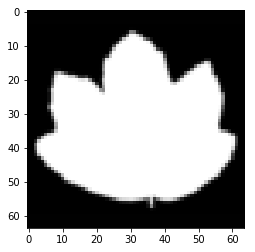

In [51]:
plt.imshow(image_data['1'], cmap='gray')
print(image_data['1'].shape)
plt.show()

In [52]:
# get labels
le = LabelEncoder()
le.fit(train.species)
# print(le.classes_)
# print(len(le.classes_))

LabelEncoder()

In [53]:
train_labels = le.transform(train.species)
# print(train_labels)
# print(len(train_labels))

In [54]:
# separate train and test from image_data
image_train = np.array([image_data[str(idx)] for idx in train.id])
image_test = np.array([image_data[str(idx)] for idx in test.id])
image_train = np.expand_dims(image_train, axis=4)
image_test = np.expand_dims(image_test, axis=4)
print(image_train.shape)
print(image_test.shape)

(990, 64, 64, 1)
(594, 64, 64, 1)


In [55]:
# split train into train and validation
# Use heavy data augmentation
# image_train (990, 64, 64, 1)
# train_labels_cat (990, 99)

train_numbers = int(len(image_train) * 0.9)
val_numbers = len(image_train) - train_numbers
train_indices = random.sample(range(0, len(image_train)), train_numbers)
val_indices = [x for x in range(0, len(image_train)) if x not in train_indices]

image_train_splitted = image_train[train_indices, :, :, :]
image_train_label_splitted = train_labels_cat[train_indices, :]
image_validation_splitted = image_train[val_indices, :, :, :]
image_validation_label_splitted = train_labels_cat[val_indices, :]

print('image_train_splitted shape', image_train_splitted.shape)
print('image_validation_splitted shape', image_validation_splitted.shape)

('image_train_splitted shape', (891, 64, 64, 1))
('image_validation_splitted shape', (99, 64, 64, 1))


In [56]:
# image generator for splitted train and validation
imgen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)
imgen.fit(image_train_splitted)
imgen_flow = imgen.flow(image_train_splitted, image_train_label_splitted, batch_size=16)

In [57]:
# # randomly split original train into train and validation
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
# for train_index, val_index in sss.split(image_train, train_labels):
#     image_train_X, image_val_X = image_train[train_index], image_train[val_index]
#     image_train_Y, image_val_Y = train_labels[train_index], train_labels[val_index]
#     print(image_train_X.shape)
#     print(image_train_Y.shape)
#     print(image_val_X.shape)
#     print(image_val_Y.shape)
#     print("TRAIN:", train_index)
#     print("VAL:", val_index)
#     plt.imshow(image_train_X[0, :, :, 0], cmap='gray')
#     plt.show()
#     print(train_index[0])
#     print(image_train_Y[0])
#     print(le.inverse_transform([image_train_Y[0]]))

In [58]:
# Convert class vectors to binary class matrices (one-hot encoding)
num_classes = 99
train_labels_cat = keras.utils.to_categorical(train_labels, num_classes)
print(image_train.shape)
print(train_labels_cat.shape)
print(train_labels_cat[0,:])

(990, 64, 64, 1)
(990, 99)
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]


# [show image] function define

In [59]:
# Keras expects batches of images, so we have to add a dimension to trick it into being nice
choosing_image = '1';
out_img = 0
path1 = '/Users/xiangfuming/Desktop/deepLeaf-master/static/output/'
path2 = '.png'
def visualize_leaf(model, im):
    # Keras expects batches of images, so we have to add a dimension to trick it into being nice
    #print im.shape
    global out_img
    global path1
    global path2
    leaf_batch = np.expand_dims(im,axis=3)
    leaf_batch = np.expand_dims(leaf_batch,axis=0)
    conv_leaf = model.predict(leaf_batch)
    conv_leaf = np.squeeze(conv_leaf, axis=0)
    plt.imshow(conv_leaf[:,:,0], cmap='gray')#Only show the first layer of the kernel in each model layer
    #path = path1+str(out_img)+path2
    #plt.savefig(path)
    #out_img = out_img+1
    plt.show()
def visualize_leaf_full(model, im, piece):
    # Keras expects batches of images, so we have to add a dimension to trick it into being nice
    #print im.shape
    global out_img
    global path1
    global path2
    leaf_batch = np.expand_dims(im,axis=3)
    leaf_batch = np.expand_dims(leaf_batch,axis=0)
    conv_leaf = model.predict(leaf_batch)
    conv_leaf = np.squeeze(conv_leaf, axis=0)
    
    for i in range(0,piece):
        print i;
        plt.imshow(conv_leaf[:,:,i], cmap='gray')
        path = path1+'kernel'+str(out_img)+'_pc'+str(i)+path2
        #plt.savefig(path)
        plt.show() 
    out_img = out_img+1

## build keras model for Images only
### model 1: following the CIFAR 10 example from Keras

In [60]:
# build keras model for Images only
# model 1: following the CIFAR 10 example from Keras

img_model = Sequential()

layer0 = Conv2D(32, (3, 3), padding='same', input_shape=image_train.shape[1:])
layer1 = Activation('relu')
layer2 = Conv2D(32, (3, 3))
layer3 = Activation('relu')
layer4 = MaxPooling2D(pool_size=(2, 2))
layer5 = Dropout(0.25)

layer6 = Conv2D(64, (3, 3), padding='same')
layer7 = Activation('relu')
layer8 = Conv2D(64, (3, 3))
layer9 = Activation('relu')
layer10 = MaxPooling2D(pool_size=(2, 2))
layer11 = Dropout(0.25)

layer12 = Flatten()
layer13 = Dense(512)
layer14 = Activation('relu')
layer15 = Dropout(0.5)
layer16 = Dense(num_classes)
layer17 = Activation('softmax')

img_model.add(layer0)
img_model.add(layer1)
img_model.add(layer2)
img_model.add(layer3)
img_model.add(layer4)
img_model.add(layer5)
img_model.add(layer6)
img_model.add(layer7)
img_model.add(layer8)
img_model.add(layer9)
img_model.add(layer10)
img_model.add(layer11)
img_model.add(layer12)
img_model.add(layer13)
img_model.add(layer14)
img_model.add(layer15)
img_model.add(layer16)
img_model.add(layer17)


json_image_model = img_model.to_json()

# Let's train the model using RMSprop
img_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#print (layer0.get_weights())
#print (img_model.get_weights())
#print img_model.layers[0].get_weights()

In [61]:
# output the model summary
img_model.count_params()
img_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
activation_55 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_56 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 31, 31, 64)        18496     
__________

In [62]:
# img_history = img_model.fit(image_train_splitted, image_train_label_splitted,
#                             batch_size=16,
#                             epochs=20,
#                             #validation_split=0.1,
#                             validation_data=(image_validation_splitted, image_validation_label_splitted),
#                             shuffle=True)

img_history = img_model.fit_generator(imgen_flow,
                                      epochs=20,
                                      validation_data=(image_validation_splitted, image_validation_label_splitted),
                                      steps_per_epoch=len(image_train)/16)

Epoch 1/20
61/61 [==============================] - 18s - loss: 4.6258 - acc: 0.0061 - val_loss: 15.1488 - val_acc: 0.0404

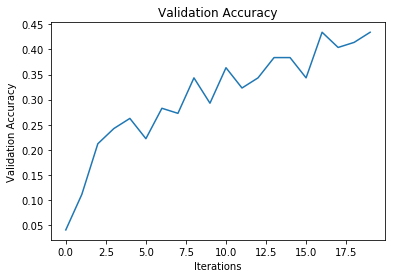

In [63]:
plt.plot(img_history.history['val_acc'])
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.show()

### Visualization for model 1

#### Re-Build Model 1

In [64]:
layer_pred0 = Conv2D(32, (3, 3), padding='same', input_shape=image_train.shape[1:], weights=img_model.layers[0].get_weights())
layer_pred1 = Activation('relu')
layer_pred2 = Conv2D(32, (3, 3), weights=img_model.layers[2].get_weights())
layer_pred3 = Activation('relu')
layer_pred4 = MaxPooling2D(pool_size=(2, 2))
layer_pred5 = Dropout(0.25)

layer_pred6 = Conv2D(64, (3, 3), padding='same', weights=img_model.layers[6].get_weights())
layer_pred7 = Activation('relu')
layer_pred8 = Conv2D(64, (3, 3), weights=img_model.layers[8].get_weights())
layer_pred9 = Activation('relu')
layer_pred10 = MaxPooling2D(pool_size=(2, 2))
layer_pred11 = Dropout(0.25)

layer_pred12 = Flatten()
layer_pred13 = Dense(512, weights=img_model.layers[13].get_weights())
layer_pred14 = Activation('relu')
layer_pred15 = Dropout(0.5)
layer_pred16 = Dense(num_classes, weights=img_model.layers[16].get_weights())
layer_pred17 = Activation('softmax')

#### Visualization

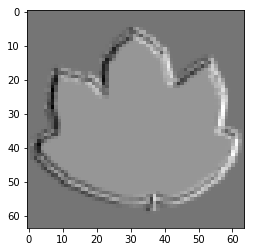

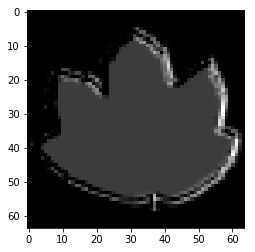

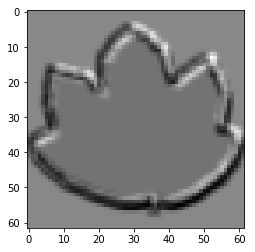

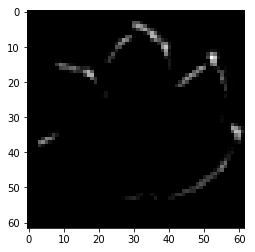

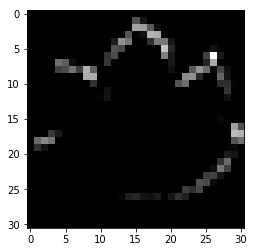

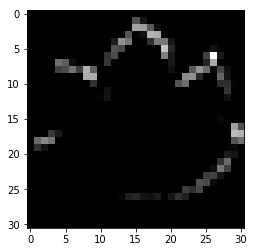

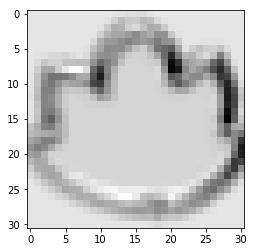

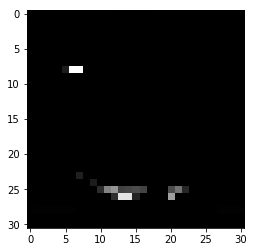

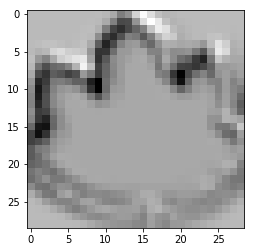

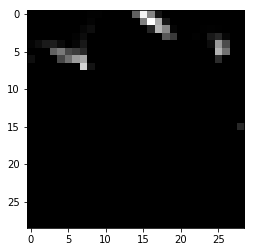

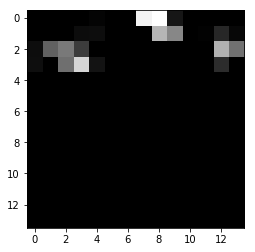

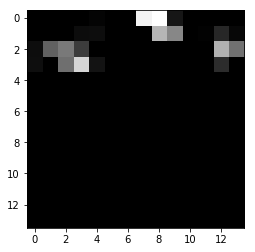

In [65]:
img_model_pred = Sequential()
img_model_pred.add(layer_pred0)
visualize_leaf(img_model_pred, image_data[choosing_image])

img_model_pred = Sequential()
img_model_pred.add(layer_pred0)
img_model_pred.add(layer_pred1)
visualize_leaf(img_model_pred, image_data[choosing_image])

img_model_pred = Sequential()
img_model_pred.add(layer_pred0)
img_model_pred.add(layer_pred1)
img_model_pred.add(layer_pred2)
visualize_leaf(img_model_pred, image_data[choosing_image])

img_model_pred = Sequential()
img_model_pred.add(layer_pred0)
img_model_pred.add(layer_pred1)
img_model_pred.add(layer_pred2)
img_model_pred.add(layer_pred3)
visualize_leaf(img_model_pred, image_data[choosing_image])

img_model_pred = Sequential()
img_model_pred.add(layer_pred0)
img_model_pred.add(layer_pred1)
img_model_pred.add(layer_pred2)
img_model_pred.add(layer_pred3)
img_model_pred.add(layer_pred4)
visualize_leaf(img_model_pred, image_data[choosing_image])

img_model_pred = Sequential()
img_model_pred.add(layer_pred0)
img_model_pred.add(layer_pred1)
img_model_pred.add(layer_pred2)
img_model_pred.add(layer_pred3)
img_model_pred.add(layer_pred4)
img_model_pred.add(layer_pred5)
visualize_leaf(img_model_pred, image_data[choosing_image])

img_model_pred = Sequential()
img_model_pred.add(layer_pred0)
img_model_pred.add(layer_pred1)
img_model_pred.add(layer_pred2)
img_model_pred.add(layer_pred3)
img_model_pred.add(layer_pred4)
img_model_pred.add(layer_pred5)
img_model_pred.add(layer_pred6)
visualize_leaf(img_model_pred, image_data[choosing_image])

img_model_pred = Sequential()
img_model_pred.add(layer_pred0)
img_model_pred.add(layer_pred1)
img_model_pred.add(layer_pred2)
img_model_pred.add(layer_pred3)
img_model_pred.add(layer_pred4)
img_model_pred.add(layer_pred5)
img_model_pred.add(layer_pred6)
img_model_pred.add(layer_pred7)
visualize_leaf(img_model_pred, image_data[choosing_image])

img_model_pred = Sequential()
img_model_pred.add(layer_pred0)
img_model_pred.add(layer_pred1)
img_model_pred.add(layer_pred2)
img_model_pred.add(layer_pred3)
img_model_pred.add(layer_pred4)
img_model_pred.add(layer_pred5)
img_model_pred.add(layer_pred6)
img_model_pred.add(layer_pred7)
img_model_pred.add(layer_pred8)
visualize_leaf(img_model_pred, image_data[choosing_image])

img_model_pred = Sequential()
img_model_pred.add(layer_pred0)
img_model_pred.add(layer_pred1)
img_model_pred.add(layer_pred2)
img_model_pred.add(layer_pred3)
img_model_pred.add(layer_pred4)
img_model_pred.add(layer_pred5)
img_model_pred.add(layer_pred6)
img_model_pred.add(layer_pred7)
img_model_pred.add(layer_pred8)
img_model_pred.add(layer_pred9)
visualize_leaf(img_model_pred, image_data[choosing_image])

img_model_pred = Sequential()
img_model_pred.add(layer_pred0)
img_model_pred.add(layer_pred1)
img_model_pred.add(layer_pred2)
img_model_pred.add(layer_pred3)
img_model_pred.add(layer_pred4)
img_model_pred.add(layer_pred5)
img_model_pred.add(layer_pred6)
img_model_pred.add(layer_pred7)
img_model_pred.add(layer_pred8)
img_model_pred.add(layer_pred9)
img_model_pred.add(layer_pred10)
visualize_leaf(img_model_pred, image_data[choosing_image])

img_model_pred = Sequential()
img_model_pred.add(layer_pred0)
img_model_pred.add(layer_pred1)
img_model_pred.add(layer_pred2)
img_model_pred.add(layer_pred3)
img_model_pred.add(layer_pred4)
img_model_pred.add(layer_pred5)
img_model_pred.add(layer_pred6)
img_model_pred.add(layer_pred7)
img_model_pred.add(layer_pred8)
img_model_pred.add(layer_pred9)
img_model_pred.add(layer_pred10)
img_model_pred.add(layer_pred11)
visualize_leaf(img_model_pred, image_data[choosing_image])

#### Connect to server

In [66]:
#build html page to show real time model

app = Flask(__name__)
Bootstrap(app)

#@app.route('/_send_json')
#def sendjson():
#    return json_image_model

@app.route('/')
def index():
    return render_template('image_model.html', data=json_image_model)
    #return layer0.get_weights()[0].toString()
if __name__ == '__main__':
    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [26/Apr/2017 21:06:42] "GET / HTTP/1.1" 200 -


### Model 2: A simpler CNN model using data augmentation method 2

In [67]:
img_model2 = Sequential()
layer2_0 = Conv2D(16, (3, 3), padding='same', input_shape=image_train.shape[1:])
layer2_1 = Activation('relu')
layer2_2 = Conv2D(16, (3, 3))
layer2_3 = Activation('relu')
layer2_4 = Conv2D(16, (3, 3))
layer2_5 = Activation('relu')

layer2_6 = Flatten()
layer2_7 = Dense(128)
layer2_8 = Activation('relu')
layer2_9 = Dense(64)
layer2_10 = Activation('relu')
layer2_11 = Dense(num_classes)
layer2_12 = Activation('softmax')

img_model2.add(layer2_0)
img_model2.add(layer2_1)
img_model2.add(layer2_2)
img_model2.add(layer2_3)
img_model2.add(layer2_4)
img_model2.add(layer2_5)
img_model2.add(layer2_6)
img_model2.add(layer2_7)
img_model2.add(layer2_8)
img_model2.add(layer2_9)
img_model2.add(layer2_10)
img_model2.add(layer2_11)
img_model2.add(layer2_12)

json_image_model2 = img_model2.to_json()

img_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
# output the model summary
img_model2.count_params()
img_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
activation_67 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 62, 62, 16)        2320      
_________________________________________________________________
activation_68 (Activation)   (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 60, 60, 16)        2320      
_________________________________________________________________
activation_69 (Activation)   (None, 60, 60, 16)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 57600)             0         
__________

In [69]:
# img_history = img_model2.fit(image_train, train_labels_cat,
#                              batch_size=16,
#                              epochs=10,
#                              validation_split=0.1,
#                              shuffle=True)

In [70]:
img_history = img_model2.fit_generator(imgen_flow,
                                       epochs=20,
                                       validation_data=(image_validation_splitted, image_validation_label_splitted),
                                       steps_per_epoch=len(image_train)/16)

Epoch 1/20
61/61 [==============================] - 12s - loss: 4.5781 - acc: 0.0306 - val_loss: 15.7925 - val_acc: 0.0202

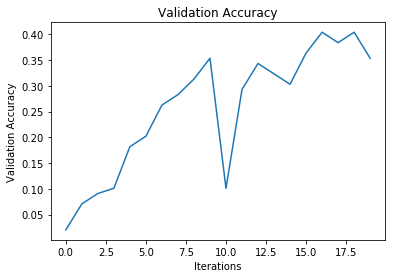

In [71]:
plt.plot(img_history.history['val_acc'])
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.show()

### Visualization for model 2

#### Re-Build model 2

In [72]:
layer2_0_pred = Conv2D(16, (3, 3), padding='same', input_shape=image_train.shape[1:], weights=img_model2.layers[0].get_weights())
layer2_1_pred = Activation('relu')
layer2_2_pred = Conv2D(16, (3, 3), weights=img_model2.layers[2].get_weights())
layer2_3_pred = Activation('relu')
layer2_4_pred = Conv2D(16, (3, 3), weights=img_model2.layers[4].get_weights())
layer2_5_pred = Activation('relu')

layer2_6_pred = Flatten()
layer2_7_pred = Dense(128, weights=img_model2.layers[7].get_weights())
layer2_8_pred = Activation('relu')
layer2_9_pred = Dense(64, weights=img_model2.layers[9].get_weights())
layer2_10_pred = Activation('relu')
layer2_11_pred = Dense(num_classes, weights=img_model2.layers[11].get_weights())
layer2_12_pred = Activation('softmax')

#### Visualization

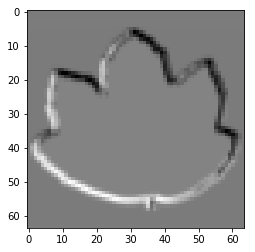

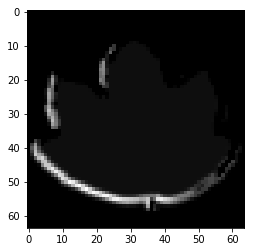

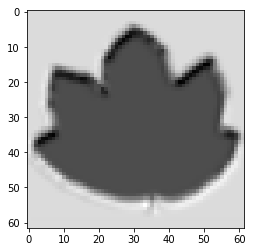

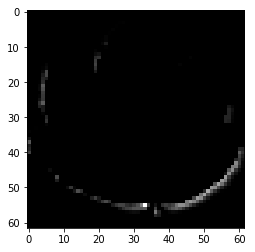

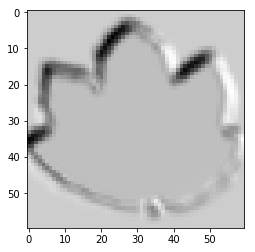

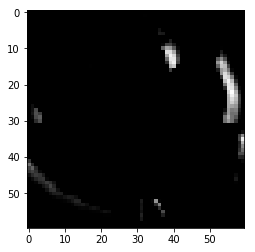

In [73]:
img_model2_pred = Sequential()
img_model2_pred.add(layer2_0)
visualize_leaf(img_model2_pred, image_data[choosing_image])

img_model2_pred = Sequential()
img_model2_pred.add(layer2_0)
img_model2_pred.add(layer2_1)
visualize_leaf(img_model2_pred, image_data[choosing_image])

img_model2_pred = Sequential()
img_model2_pred.add(layer2_0)
img_model2_pred.add(layer2_1)
img_model2_pred.add(layer2_2)
visualize_leaf(img_model2_pred, image_data[choosing_image])

img_model2_pred = Sequential()
img_model2_pred.add(layer2_0)
img_model2_pred.add(layer2_1)
img_model2_pred.add(layer2_2)
img_model2_pred.add(layer2_3)
visualize_leaf(img_model2_pred, image_data[choosing_image])

img_model2_pred = Sequential()
img_model2_pred.add(layer2_0)
img_model2_pred.add(layer2_1)
img_model2_pred.add(layer2_2)
img_model2_pred.add(layer2_3)
img_model2_pred.add(layer2_4)
visualize_leaf(img_model2_pred, image_data[choosing_image])

img_model2_pred = Sequential()
img_model2_pred.add(layer2_0)
img_model2_pred.add(layer2_1)
img_model2_pred.add(layer2_2)
img_model2_pred.add(layer2_3)
img_model2_pred.add(layer2_4)
img_model2_pred.add(layer2_5)
visualize_leaf(img_model2_pred, image_data[choosing_image])

#### Connect to server

In [74]:
#build html page to show real time model

app = Flask(__name__)
Bootstrap(app)

#@app.route('/_send_json')
#def sendjson():
#    return json_image_model

@app.route('/')
def index():
    return render_template('image_model.html', data=json_image_model2)
    #return layer0.get_weights()[0].toString()
if __name__ == '__main__':
    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [26/Apr/2017 21:14:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2017 21:14:47] "GET /static/img/leaf.jpg HTTP/1.1" 304 -
127.0.0.1 - - [26/Apr/2017 21:14:50] "GET /static/output/layer0.png HTTP/1.1" 404 -
127.0.0.1 - - [26/Apr/2017 21:14:51] "GET /static/output/layer1.png HTTP/1.1" 404 -
127.0.0.1 - - [26/Apr/2017 21:14:52] "GET /static/output/layer1.png HTTP/1.1" 404 -


## Using Features Only

In [75]:
# build keras model for Features only
feat_model = Sequential()
feat_model.add(Dense(512, input_dim=192, kernel_initializer='uniform', activation='relu'))
feat_model.add(Dropout(0.3))
feat_model.add(Dense(256, activation='sigmoid'))
feat_model.add(Dropout(0.3))
feat_model.add(Dense(99, activation='softmax'))

feat_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])

In [76]:
# output the model summary
feat_model.count_params()
feat_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 512)               98816     
_________________________________________________________________
dropout_34 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 99)                25443     
Total params: 255,587
Trainable params: 255,587
Non-trainable params: 0
_________________________________________________________________


In [77]:
feat_history = feat_model.fit(feat_train, train_labels_cat,
                              batch_size=16,
                              epochs=50,
                              validation_split=0.1,
                              shuffle=True)

Train on 891 samples, validate on 99 samples
Epoch 1/50
891/891 [==============================] - 0s - loss: 4.2477 - acc: 0.1212 - val_loss: 3.5011 - val_acc: 0.3737
Epoch 2/50
891/891 [==============================] - 0s - loss: 2.9315 - acc: 0.4411 - val_loss: 2.3825 - val_acc: 0.7273
Epoch 3/50
891/891 [==============================] - 0s - loss: 1.8817 - acc: 0.7306 - val_loss: 1.4283 - val_acc: 0.8687

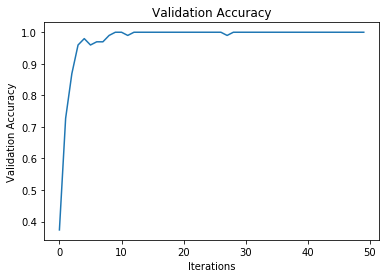

In [78]:
plt.plot(feat_history.history['val_acc'])
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.show()

In [79]:
# do prediction
pred = feat_model.predict_proba(feat_test)
columns = sorted(train.species.unique())
pred = pandas.DataFrame(pred, index=test.id, columns=columns)
output = open('prediction_fully_connected.csv','w')
output.write(pred.to_csv())
output.close()

 32/594 [>.............................] - ETA: 2s